# Pipeline for heartbeat Binary classification with CNN model, mit shifted data

We want to load the scaler that we created for mit train set, the mit shift method as transform and the model trained with cnn for binary classification.   
So that we can use the pipeline in the product env. 

If you don't have the input files: run the following notebooks   
1. 'preprocessing_mit_binary_shift_minmax_oversampling.ipynb' to generate the preprocessed data for model train and also save the scaler that we are going to use.
2. 'modeling_mit_binary_shift_CNN.ipynb' to train the model with the cnn and save the model that we are going to use. 
3. 'preprocessing_mit_clean.ipynb' to add columns and encode target as binary

Input file:   (scaler & model)   
mit_binary_minmax_scaler.joblib (saved mit minmax scaler)   
model_mit_binary_shift_cnn.h5 (saved binary model with cnn and shift data)  
mitbih_test_clean.csv   (raw file with columns added and target encoded to test pipeline)  

output file:    
mit_binary_classification_pipeline.joblib

In [45]:
import sys
import os

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q
    !pip install matplotlib -q
    !pip install seaborn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive.
    data_path = '/content/drive/MyDrive/heartbeat-deep-model/'
    model_path = data_path
    pipeline_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_path = '../models/'
    pipeline_path = '../pipelines/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


In [46]:
from sklearn.pipeline import Pipeline 
from tensorflow.keras.models import load_model
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, roc_curve
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import joblib

scaler_file_name = 'mit_binary_minmax_scaler.joblib'
model_file_name = 'model_mit_binary_shift_cnn.h5'
mit_test_file = 'mitbih_test_clean.csv'

In [47]:
### define the transformer 
def find_top_n_peaks(signal, n=5):
    # Find highest peaks
    high_peaks, _ = find_peaks(signal)
    high_peaks_values = signal[high_peaks]
    top_high_peaks = sorted(zip(high_peaks, high_peaks_values), key=lambda x: -x[1])[:n]

    # Find lowest peaks 
    low_peaks, _ = find_peaks(signal * -1) # -1 means invert the signal to find the lowest peaks
    low_peaks_values = signal[low_peaks]
    top_low_peaks = sorted(zip(low_peaks, low_peaks_values), key=lambda x: x[1])[:n]

    return top_high_peaks, top_low_peaks

def find_peak_one_row(data) -> int:
    ### find the peak which take the whole ecg signal 
    ### return the index 
    high_peaks, _ = find_peaks(data)
    # as we need about 75 - 125 signal to identify the whole ecg period
    # in this case the maximum R wave may appear at first 6-10 , or 8-15
    # based on that we can conclude the valid peak may exists in range of [6, 160 ]
    # valid_high_peaks = [ value for value in high_peaks if 6<=value<=160]
    valid_high_peaks = [ value for value in high_peaks if 15<=value<=150]
    high_peaks_values = data[high_peaks]
    high_peaks_values = data[ valid_high_peaks if len(valid_high_peaks)> 0 else high_peaks   ]
    top_high_peaks = sorted(zip(high_peaks, high_peaks_values), key=lambda x: -x[1])[:1]

    return top_high_peaks[0][0]

def shift_row(data, center): 
    peak = find_peak_one_row(data)
    target = data[-1]

    # Calculate the shift needed to move the highest value to the center
    shift = center - peak
    
    # Create an output array filled with None
    shifted_array = [0] * len(data)
    
    # Shift the elements and handle out-of-bound cases
    for i in range(len(data)):
        new_index = i + shift
        if 0 <= new_index < len(data):  # Ensure new index is within bounds
            shifted_array[new_index] = data[i]
    shifted_array[-1] = target
    return shifted_array
    # return pd.Series(shifted_array)

def get_shift_dataframe(df, center):
    
    df_shifted = df.apply( lambda row:  shift_row(row, center), axis=1)

    return df_shifted

class MitDataShiftTransformer(BaseEstimator, TransformerMixin): 
    """
    A transformer to shift mit heartbeat ecg signal, to align R wave peak to a specific position to better predict 
    """
    
    def __init__(self, r_peak_position='87'):
        """
        r_peak_position: default value 87 as we get the average R wave peak at 87 for mit train set. 
        """
        self.r_peak_position = r_peak_position
    
    def fit(self, X, y=None):
        """
        Nothing to record, as we already get the r_peak_position from the mit train set
        """
        return self
    
    def transform(self, X): 
        print('X transform shape', X.shape)
        X_transformed = np.array( [self._get_shifted_row(row) for row in X])
        print('X_transformed', X_transformed.shape)
        return X_transformed
    
    def _get_shifted_row(self, data):
        peak = self._find_peak_one_row(data)
        # Calculate the shift needed to move the highest value to the center
        shift = self.r_peak_position - peak
        
        # Create an output array filled with None
        shifted_array = np.zeros(len(data)) ## [0] * len(data)
        
        # Shift the elements and handle out-of-bound cases
        for i in range(len(data)):
            new_index = i + shift
            if 0 <= new_index < len(data):  # Ensure new index is within bounds
                shifted_array[new_index] = data[i]
        return shifted_array
        # return pd.Series(shifted_array)
        
    def _find_peak_one_row(self, data)-> int:
         ### find the peak which take the whole ecg signal 
        ### return the index 
        high_peaks, _ = find_peaks(data)

        # as we need about 75 - 125 signal to identify the whole ecg period
        # in this case the maximum R wave may appear at first 6-10 , or 8-15
        # based on that we can conclude the valid peak may exists in range of [6, 160 ]
        valid_high_peaks = [ value for value in high_peaks if 6<=value<=160]
        high_peaks_values = data[high_peaks]
        high_peaks_values = data[ valid_high_peaks if len(valid_high_peaks)> 0 else high_peaks   ]
        top_high_peaks = sorted(zip(high_peaks, high_peaks_values), key=lambda x: -x[1])[:1]

        return top_high_peaks[0][0]

In [48]:
from  sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
shift_transform = MitDataShiftTransformer(87) # 87 is the average R peak position for mit train set
scaler = joblib.load(data_path + scaler_file_name)


model = load_model(model_path + model_file_name)

mit_binary_classification_pipeline = Pipeline([
    ('shift_transform', shift_transform),
    ('scaler', scaler),
    ('cnn', model)
])


c:\Users\Isabell Gurstein\anaconda3\envs\DataScientestNotebooksEnv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


X transform shape (20284, 187)
X_transformed (20284, 187)
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Optimal Threshold: 0.12


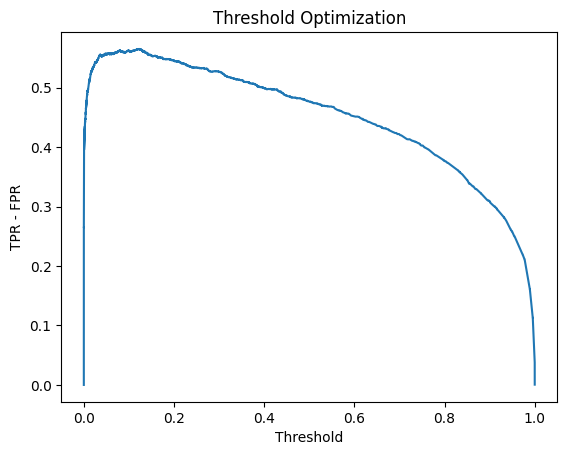

In [49]:
# test pipeline

mit_test = pd.read_csv(data_path + mit_test_file)
# mit_test = pd.read_csv(data_path + 'mitbih_binary_test_shift_minmax_oversampling.csv')

X_test_values = mit_test.drop(columns=['target']).values
y_test_values = mit_test['target'].values

y_predict = mit_binary_classification_pipeline.predict(X_test_values).ravel()

# Calculate the optimal threshold
fpr, tpr, thresholds = roc_curve(y_test_values, y_predict) # threshold for the decision function to maximize the true positive rate while minimizing the false positive rate
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")


import matplotlib.pyplot as plt

plt.plot(thresholds, tpr - fpr)
plt.xlabel('Threshold')
plt.ylabel('TPR - FPR')
plt.title('Threshold Optimization')
plt.show()


In [50]:
# Convert the probabilities to class labels
y_pred_class = (y_predict >= optimal_threshold).astype(int)

# Display classification report
report_dict = classification_report(y_test_values, y_pred_class, output_dict=True)
print("Classification Report:")
print(pd.DataFrame(report_dict).transpose())

# format the classification report into table
report = classification_report(y_test_values, y_pred_class, output_dict=True)
df = pd.DataFrame(report).transpose()

Classification Report:
              precision    recall  f1-score       support
0              0.956077  0.917872  0.936585  18118.000000
1              0.485121  0.647276  0.554589   2166.000000
accuracy       0.888977  0.888977  0.888977      0.888977
macro avg      0.720599  0.782574  0.745587  20284.000000
weighted avg   0.905786  0.888977  0.895794  20284.000000


In [51]:
# save the shift transformer and model 
# so that the product can load file to make predict. 
joblib.dump(mit_binary_classification_pipeline,  pipeline_path+'mit_binary_classification_pipeline.joblib')

['../pipelines/mit_binary_classification_pipeline.joblib']

In [52]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2025-02-03 14:58:17.854517
